# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [50]:
import numpy as np
import os
import imageio.v2 as imageio
from skimage.transform import resize, rescale

import datetime
import os

import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [51]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [52]:
train_doc = np.random.permutation(open('/kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/val.csv').readlines())

In [53]:
## Checking the GPU configuration

!nvidia-smi

Wed Dec 21 09:31:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |  16017MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [54]:
image1 = imageio.imread("/kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
print("Image1 Shape: ", image1.shape)
image2 = imageio.imread("/kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")
print("Image2 Shape: ", image2.shape)

Image1 Shape:  (360, 360, 3)
Image2 Shape:  (120, 160, 3)


In [55]:
#Lets define total number of classes
num_classes=5

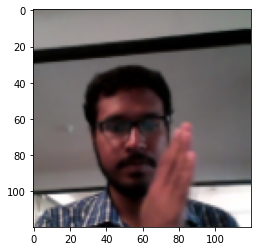

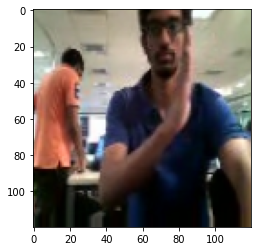

In [56]:
#Let us test the image resizing with 2 sample images from the dataset if the resizing works appropriately
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()

OBSERVATION: Resizing is working as expected with the image sample.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [57]:
def generator(source_path, folder_list, batch_size, num_images, height=160, width=160, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames=30
    img_idx = np.round(np.linspace(0, total_frames-1 , num_images)).astype(int)  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, num_images, height, width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)
                    
                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


# Common Utils

**Common Utitlity for model callback**

In [58]:
def model_callbacks(folder_name):
    model_name = folder_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

    return [checkpoint, LR, earlystop]

**Common utility to calculate steps**

In [59]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

**Common utility to plot loss and accuracy**

In [60]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

**OBSERVATION**: Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [61]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train'
val_path = '/kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [64]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

### Conv3d Models

In [14]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=30, height=160, width=160):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2), padding='same'))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2), padding='same'))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2), padding='same'))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2, 2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

OBSERVATION:We hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 60..we get the OOM error.

### Let us try to analyse the impact of different batch size,epochs, number of frames and image resolution from 'model_conv3D_1' to 'model_conv3D_9' in order to find a configuration that would use the GPU power appropriately.

In [17]:
num_epochs = 1 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 50  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 1
# batch size = 50
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_______________________________________________________________

2022-12-20 11:18:48.323700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:18:48.421438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:18:48.422229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:18:48.423874: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [67]:
callbacks_list = model_callbacks("model_conv3D_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [68]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 50


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  from ipykernel import kernelapp as app


12/14 [========================>.....] - ETA: 40s - loss: 1.4103 - categorical_accuracy: 0.5167 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


14/14 [==============================] - 327s 25s/step - loss: 1.4068 - categorical_accuracy: 0.5158 - val_loss: 2.5884 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_conv3D_1_2022-12-2011_03_37.434700/model-00001-1.40682-0.51584-2.58843-0.22000.h5


In [18]:
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 50  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 2
# batch size = 50
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_8 (Activation)    (None, 10, 80, 80, 32)    0         
_____________________________________________________________

In [19]:
callbacks_list = model_callbacks("model_conv3D_2")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [20]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 50


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-20 11:19:21.023451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-12-20 11:19:23.539099: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


14/14 [==============================] - 218s 16s/step - loss: 1.4774 - categorical_accuracy: 0.4947 - val_loss: 1.9146 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_conv3D_2_2022-12-2011_18_48.187653/model-00001-1.47743-0.49472-1.91458-0.20000.h5
Epoch 2/2
14/14 [==============================] - 175s 13s/step - loss: 0.7014 - categorical_accuracy: 0.7330 - val_loss: 2.4925 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_conv3D_2_2022-12-2011_18_48.187653/model-00002-0.70143-0.73303-2.49251-0.16000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


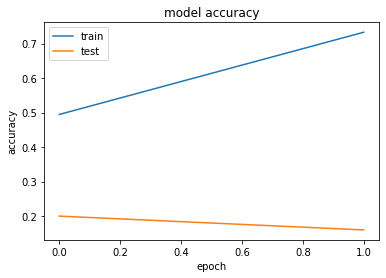

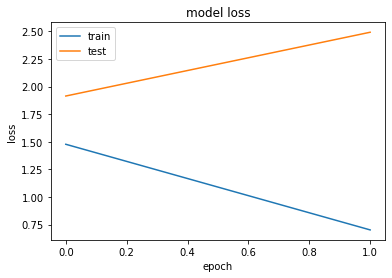

In [21]:
plot_loss_accuracy(history)

In [24]:
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 50  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 15
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 2
# batch size = 50
# num_frames per video = 15
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 15, 160, 160, 16)  1312      
_________________________________________________________________
activation_18 (Activation)   (None, 15, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_19 (Activation)   (None, 8, 80, 80, 32)     0         
_____________________________________________________________

In [25]:
callbacks_list = model_callbacks("model_conv3D_3")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [26]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 50
Epoch 1/2
14/14 [==============================] - 142s 11s/step - loss: 1.5611 - categorical_accuracy: 0.4857 - val_loss: 1.7570 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_conv3D_3_2022-12-2011_18_48.187653/model-00001-1.56110-0.48567-1.75703-0.24000.h5
Epoch 2/2
14/14 [==============================] - 130s 10s/step - loss: 0.8203 - categorical_accuracy: 0.6878 - val_loss: 1.9935 - val_categorical_accuracy: 0.2800

Epoch 00002: saving model to model_conv3D_3_2022-12-2011_18_48.187653/model-00002-0.82025-0.68778-1.99351-0.28000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


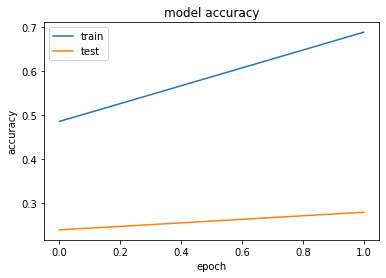

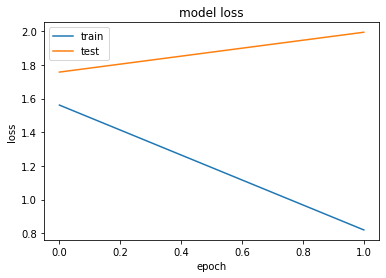

In [27]:
plot_loss_accuracy(history)

In [28]:
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 30  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 2
# batch size = 30
# num_frames per video = 30
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 15, 80, 80, 32)    0         
_____________________________________________________________

In [29]:
callbacks_list = model_callbacks("model_conv3D_4")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [30]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 30
Epoch 1/2
23/23 [==============================] - 283s 13s/step - loss: 1.4124 - categorical_accuracy: 0.5098 - val_loss: 2.1618 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_conv3D_3_2022-12-2011_18_48.187653/model-00001-1.41235-0.50980-2.16183-0.28000.h5
Epoch 2/2
23/23 [==============================] - 265s 12s/step - loss: 0.9849 - categorical_accuracy: 0.6395 - val_loss: 5.6778 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_conv3D_3_2022-12-2011_18_48.187653/model-00002-0.98489-0.63952-5.67782-0.24000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


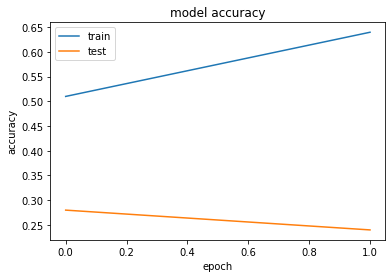

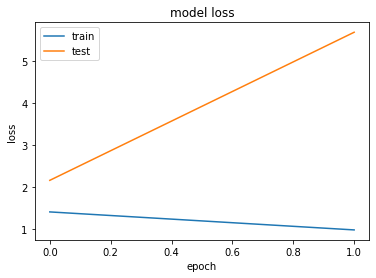

In [31]:
plot_loss_accuracy(history)

In [32]:
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 30  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 15
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 2
# batch size = 30
# num_frames per video = 15
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 15, 160, 160, 16)  1312      
_________________________________________________________________
activation_32 (Activation)   (None, 15, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 15, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_33 (Activation)   (None, 8, 80, 80, 32)     0         
_____________________________________________________________

In [33]:
callbacks_list = model_callbacks("model_conv3D_5")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [34]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 30
Epoch 1/2
23/23 [==============================] - 136s 6s/step - loss: 1.4743 - categorical_accuracy: 0.4525 - val_loss: 1.8663 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_conv3D_3_2022-12-2011_18_48.187653/model-00001-1.47427-0.45249-1.86630-0.22000.h5
Epoch 2/2
23/23 [==============================] - 144s 7s/step - loss: 1.0421 - categorical_accuracy: 0.6320 - val_loss: 2.2867 - val_categorical_accuracy: 0.3400

Epoch 00002: saving model to model_conv3D_3_2022-12-2011_18_48.187653/model-00002-1.04214-0.63198-2.28666-0.34000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


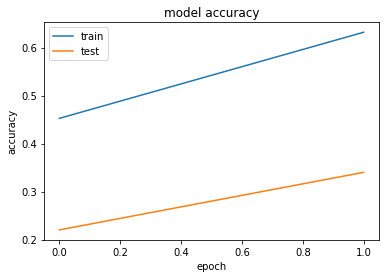

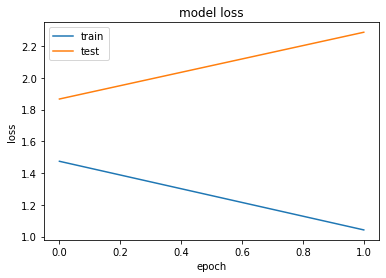

In [35]:
plot_loss_accuracy(history)

In [36]:
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 50  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 100
width = 100

model = conv3D(num_images=num_frames, height=height, width=width)

print (model.summary())

# epochs = 2
# batch size = 50
# num_frames per video = 20
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation_39 (Activation)   (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
activation_40 (Activation)   (None, 10, 50, 50, 32)    0         
_____________________________________________________________

In [38]:
callbacks_list = model_callbacks("model_conv3D_6")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 50
Epoch 1/2
14/14 [==============================] - 176s 13s/step - loss: 1.4409 - categorical_accuracy: 0.4947 - val_loss: 2.3724 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_conv3D_6_2022-12-2011_18_48.187653/model-00001-1.44089-0.49472-2.37244-0.21000.h5
Epoch 2/2
14/14 [==============================] - 155s 12s/step - loss: 0.8405 - categorical_accuracy: 0.6848 - val_loss: 3.3404 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_conv3D_6_2022-12-2011_18_48.187653/model-00002-0.84054-0.68477-3.34038-0.21000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


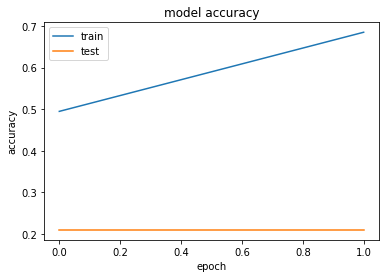

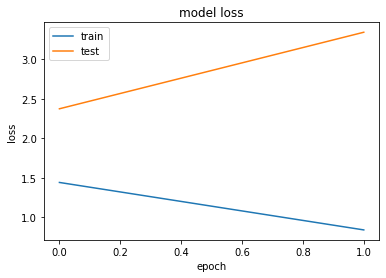

In [39]:
plot_loss_accuracy(history)

In [40]:
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 50  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 15
print ('# num_frames per video =', num_frames)
height = 100
width = 100

model = conv3D(num_images=num_frames, height=height, width=width)

print (model.summary())

# epochs = 2
# batch size = 50
# num_frames per video = 15
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_46 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_47 (Activation)   (None, 8, 50, 50, 32)     0         
_____________________________________________________________

In [41]:
callbacks_list = model_callbacks("model_conv3D_7")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 50
Epoch 1/2
14/14 [==============================] - 123s 9s/step - loss: 1.5360 - categorical_accuracy: 0.4344 - val_loss: 1.6100 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_conv3D_7_2022-12-2011_18_48.187653/model-00001-1.53603-0.43439-1.61003-0.26000.h5
Epoch 2/2
14/14 [==============================] - 119s 9s/step - loss: 0.8966 - categorical_accuracy: 0.6546 - val_loss: 2.8843 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_conv3D_7_2022-12-2011_18_48.187653/model-00002-0.89657-0.65460-2.88430-0.30000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


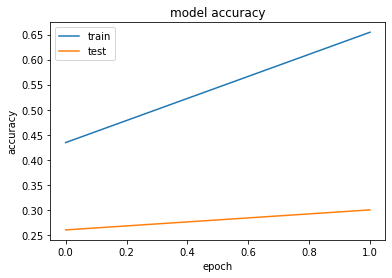

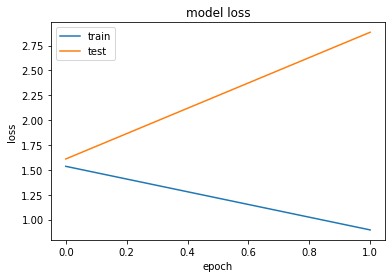

In [42]:
plot_loss_accuracy(history)

In [30]:
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 30  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 100
width = 100

model = conv3D(num_images=num_frames, height=height, width=width)

print (model.summary())

# epochs = 2
# batch size = 30
# num_frames per video = 30


2022-12-20 12:29:06.615526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 12:29:06.712433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 12:29:06.713233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 12:29:06.714567: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 50, 50, 32)    1

In [31]:
callbacks_list = model_callbacks("model_conv3D_8")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 30


2022-12-20 12:29:51.432111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-12-20 12:29:53.828486: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


23/23 [==============================] - 244s 11s/step - loss: 1.5491 - categorical_accuracy: 0.4359 - val_loss: 1.8610 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_conv3D_8_2022-12-2012_28_59.259476/model-00001-1.54913-0.43590-1.86098-0.28000.h5
Epoch 2/2
23/23 [==============================] - 186s 8s/step - loss: 0.9773 - categorical_accuracy: 0.6380 - val_loss: 3.5126 - val_categorical_accuracy: 0.1300

Epoch 00002: saving model to model_conv3D_8_2022-12-2012_28_59.259476/model-00002-0.97732-0.63801-3.51259-0.13000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


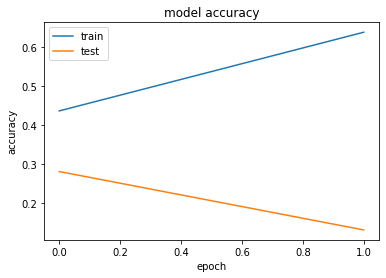

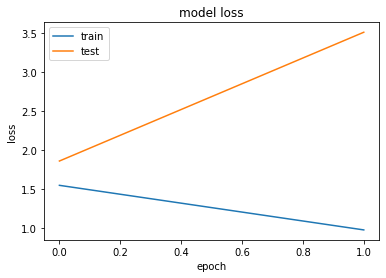

In [32]:
plot_loss_accuracy(history)

In [33]:
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 30  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 15
print ('# num_frames per video =', num_frames)
height = 100
width = 100

model = conv3D(num_images=num_frames, height=height, width=width)

print (model.summary())

# epochs = 2
# batch size = 30
# num_frames per video = 15
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_8 (Activation)    (None, 8, 50, 50, 32)     0         
_____________________________________________________________

In [34]:
callbacks_list = model_callbacks("model_conv3D_9")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 30
Epoch 1/2
23/23 [==============================] - 95s 4s/step - loss: 1.4919 - categorical_accuracy: 0.4495 - val_loss: 2.1908 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_conv3D_9_2022-12-2012_28_59.259476/model-00001-1.49189-0.44947-2.19076-0.16000.h5
Epoch 2/2
23/23 [==============================] - 93s 4s/step - loss: 0.9512 - categorical_accuracy: 0.6425 - val_loss: 2.8324 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to model_conv3D_9_2022-12-2012_28_59.259476/model-00002-0.95116-0.64253-2.83242-0.17000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


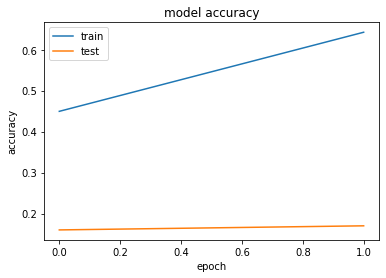

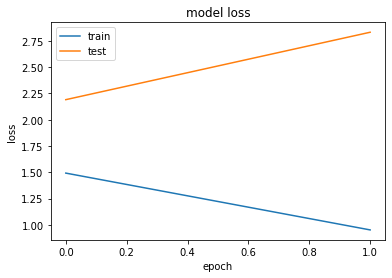

In [35]:
plot_loss_accuracy(history)

OBSERVATIONS:
* From the above experiments, it is evident that "image resolution" and "number of frames" in sequence have more impact on training time than batch_size
* We can consider the Batch Size around 15-50
* We will change the resoulution 160 * 160, 120 * 120 according to the model performance

##  Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120) with no. of epochs=25, batch size=15, no. of frames=30

In [16]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames, height=height, width=width)

print (model.summary())

# epochs = 25
# batch size = 15
# num_frames per video = 30


2022-12-20 16:37:45.343698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 32)    1

2022-12-20 16:37:45.475507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 16:37:45.476328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 16:37:45.478487: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 16:37:45.478834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [17]:
callbacks_list = model_callbacks("model_conv3D_10")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 15


2022-12-20 16:38:26.695007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-12-20 16:38:28.749956: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


45/45 [==============================] - 348s 8s/step - loss: 1.4796 - categorical_accuracy: 0.4615 - val_loss: 4.6239 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_conv3D_10_2022-12-2016_35_57.926124/model-00001-1.47961-0.46154-4.62393-0.24000.h5
Epoch 2/25
45/45 [==============================] - 211s 5s/step - loss: 1.0640 - categorical_accuracy: 0.6048 - val_loss: 7.2697 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_conv3D_10_2022-12-2016_35_57.926124/model-00002-1.06398-0.60483-7.26970-0.22000.h5
Epoch 3/25
45/45 [==============================] - 213s 5s/step - loss: 0.7790 - categorical_accuracy: 0.7074 - val_loss: 6.6608 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_conv3D_10_2022-12-2016_35_57.926124/model-00003-0.77898-0.70739-6.66076-0.26000.h5
Epoch 4/25
45/45 [==============================] - 213s 5s/step - loss: 0.6353 - categorical_accuracy: 0.7511 - val_loss: 13.7461 - val_categorical_accuracy: 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


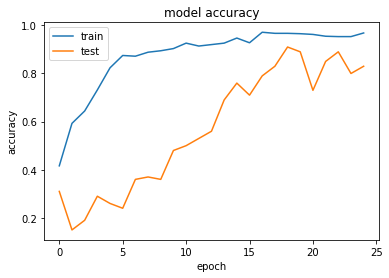

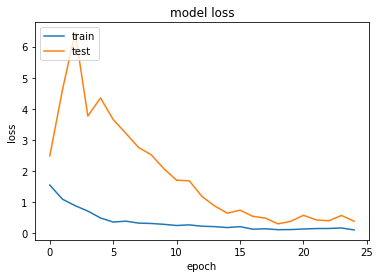

In [38]:
plot_loss_accuracy(history)

##  Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160) with no. of epochs=25, batch size=15, no. of frames=30

In [16]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=height, width=width)

print (model.summary())

# epochs = 25
# batch size = 15
# num_frames per video = 30


2022-12-20 18:15:19.428669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 18:15:19.515159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 18:15:19.515969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

2022-12-20 18:15:19.517881: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 18:15:19.518177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 18:15:19.518944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 18:15:19.519640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [17]:
callbacks_list = model_callbacks("model_conv3D_11")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 15


2022-12-20 18:15:29.762075: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-12-20 18:15:31.923590: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


45/45 [==============================] - 387s 9s/step - loss: 1.5807 - categorical_accuracy: 0.4600 - val_loss: 3.4434 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_conv3D_11_2022-12-2018_14_48.639172/model-00001-1.58072-0.46003-3.44345-0.27000.h5
Epoch 2/25
45/45 [==============================] - 255s 6s/step - loss: 1.0882 - categorical_accuracy: 0.5732 - val_loss: 3.2127 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_conv3D_11_2022-12-2018_14_48.639172/model-00002-1.08818-0.57315-3.21270-0.20000.h5
Epoch 3/25
45/45 [==============================] - 251s 6s/step - loss: 0.9474 - categorical_accuracy: 0.6456 - val_loss: 7.5122 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_conv3D_11_2022-12-2018_14_48.639172/model-00003-0.94739-0.64555-7.51224-0.16000.h5
Epoch 4/25
45/45 [==============================] - 254s 6s/step - loss: 1.0053 - categorical_accuracy: 0.6214 - val_loss: 6.7913 - val_categorical_accuracy: 0

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


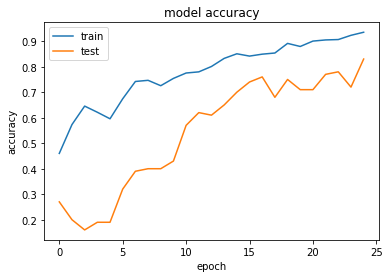

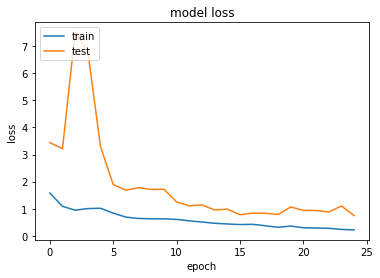

In [18]:
plot_loss_accuracy(history)

##  Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120) with no. of epochs=25, batch size=15, no. of frames=20

In [15]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames, height=height, width=width)

print (model.summary())

# epochs = 25
# batch size = 15
# num_frames per video = 20


2022-12-20 20:23:00.569715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:23:00.661695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:23:00.662573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:23:00.664059: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 60, 60, 32)    1

In [16]:
callbacks_list = model_callbacks("model_conv3D_12")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 15


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-20 20:23:10.130336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-12-20 20:23:12.132771: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


45/45 [==============================] - 326s 7s/step - loss: 1.4501 - categorical_accuracy: 0.4404 - val_loss: 4.2764 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_conv3D_12_2022-12-2020_22_11.868483/model-00001-1.45006-0.44042-4.27638-0.22000.h5
Epoch 2/25
45/45 [==============================] - 135s 3s/step - loss: 1.0277 - categorical_accuracy: 0.6063 - val_loss: 4.6011 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_conv3D_12_2022-12-2020_22_11.868483/model-00002-1.02770-0.60633-4.60107-0.22000.h5
Epoch 3/25
45/45 [==============================] - 135s 3s/step - loss: 0.8986 - categorical_accuracy: 0.6667 - val_loss: 4.6485 - val_categorical_accuracy: 0.2700

Epoch 00003: saving model to model_conv3D_12_2022-12-2020_22_11.868483/model-00003-0.89865-0.66667-4.64852-0.27000.h5
Epoch 4/25
45/45 [==============================] - 136s 3s/step - loss: 0.7148 - categorical_accuracy: 0.7285 - val_loss: 6.3064 - val_categorical_accuracy: 0

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


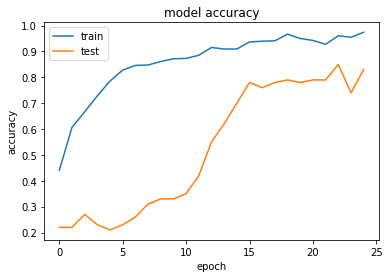

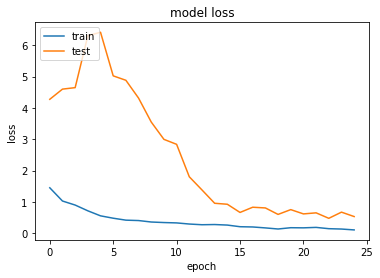

In [17]:
plot_loss_accuracy(history)

# **Transfer Learninng - MobileNet Conv2d + GRU**

In [65]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

**Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes**

In [34]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True, height=height, width=width)

print (model.summary())

# epochs = 25
# batch size = 15
# num_frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               443136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
____

In [35]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - 288s 6s/step - loss: 1.1167 - categorical_accuracy: 0.5415 - val_loss: 0.7185 - val_categorical_accuracy: 0.6900

Epoch 00001: saving model to model_retrain_mobilenet_gru_2022-12-2021_43_03.824346/model-00001-1.11667-0.54148-0.71850-0.69000.h5
Epoch 2/25
45/45 [==============================] - 208s 5s/step - loss: 0.5588 - categorical_accuracy: 0.7843 - val_loss: 0.3926 - val_categorical_accuracy: 0.8400

Epoch 00002: saving model to model_retrain_mobilenet_gru_2022-12-2021_43_03.824346/model-00002-0.55885-0.78431-0.39258-0.84000.h5
Epoch 3/25
45/45 [==============================] - 211s 5s/step - loss: 0.2637 - categorical_accuracy: 0.8959 - val_loss: 0.3129 - val_categorical_accuracy: 0.8600

Epoch 00003: saving model to model_retrain_mobilenet_gru_2022-12-2021_43_03.824346/model-00003-0.26369-0.89593-0.31292-0.86000.h5
Epo

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


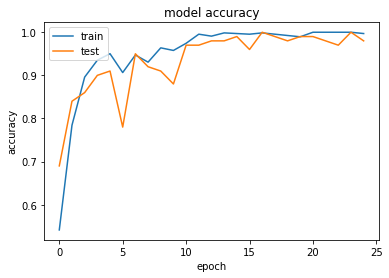

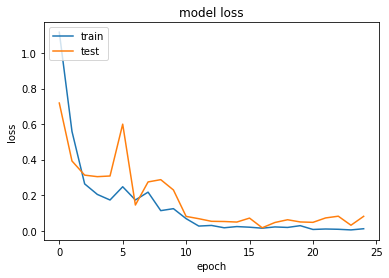

In [37]:
plot_loss_accuracy(history)

**Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set**

In [47]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True, height=height, width=width)

print (model.summary())

# epochs = 25
# batch size = 15
# num_frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_9 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
____

In [48]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_trans")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width, augment=True)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width, augment=True)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - 279s 6s/step - loss: 1.2060 - categorical_accuracy: 0.5008 - val_loss: 1.0696 - val_categorical_accuracy: 0.5700

Epoch 00001: saving model to model_retrain_mobilenet_gru_trans_2022-12-2107_41_23.422556/model-00001-1.20598-0.50075-1.06962-0.57000.h5
Epoch 2/25
45/45 [==============================] - 232s 5s/step - loss: 0.5169 - categorical_accuracy: 0.8115 - val_loss: 0.7270 - val_categorical_accuracy: 0.7200

Epoch 00002: saving model to model_retrain_mobilenet_gru_trans_2022-12-2107_41_23.422556/model-00002-0.51689-0.81146-0.72704-0.72000.h5
Epoch 3/25
45/45 [==============================] - 235s 5s/step - loss: 0.3318 - categorical_accuracy: 0.8824 - val_loss: 0.3627 - val_categorical_accuracy: 0.8700

Epoch 00003: saving model to model_retrain_mobilenet_gru_trans_2022-12-2107_41_23.422556/model-00003-0.33179-0.88235-0.36

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


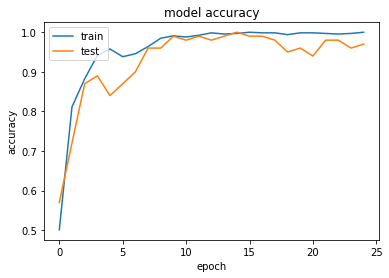

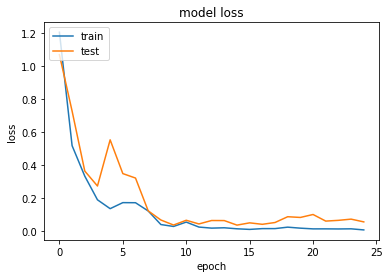

In [49]:
plot_loss_accuracy(history)

**Mobilenet (fine tune) + GRU (128 cells) + 128 dense nodes**

In [32]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True, height=height, width=width, fine_tune=True)

print (model.summary())

# epochs = 25
# batch size = 15
# num_frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
____

In [33]:
callbacks_list = model_callbacks("model_finetune_mobilenet_gru")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - 229s 5s/step - loss: 1.2121 - categorical_accuracy: 0.4947 - val_loss: 0.9062 - val_categorical_accuracy: 0.6300

Epoch 00001: saving model to model_finetune_mobilenet_gru_2022-12-2106_17_04.396169/model-00001-1.21209-0.49472-0.90625-0.63000.h5
Epoch 2/25
45/45 [==============================] - 205s 5s/step - loss: 0.5278 - categorical_accuracy: 0.8009 - val_loss: 0.3293 - val_categorical_accuracy: 0.8700

Epoch 00002: saving model to model_finetune_mobilenet_gru_2022-12-2106_17_04.396169/model-00002-0.52783-0.80090-0.32926-0.87000.h5
Epoch 3/25
45/45 [==============================] - 212s 5s/step - loss: 0.2414 - categorical_accuracy: 0.9140 - val_loss: 0.3483 - val_categorical_accuracy: 0.8900

Epoch 00003: saving model to model_finetune_mobilenet_gru_2022-12-2106_17_04.396169/model-00003-0.24140-0.91403-0.34828-0.89000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


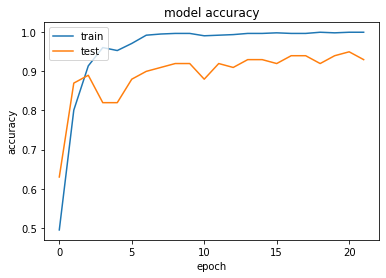

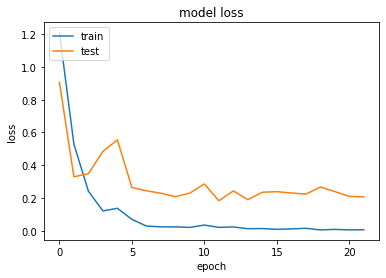

In [34]:
plot_loss_accuracy(history)

**Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes**

In [66]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=False, height=height, width=width, fine_tune=False)

print (model.summary())

# epochs = 25
# batch size = 15
# num_frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
____

In [67]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=height, width=width)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition-dataset/Gesture_Recognition_dataset/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - 240s 5s/step - loss: 1.2599 - categorical_accuracy: 0.4766 - val_loss: 1.0004 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_retrain_mobilenet_lstm_2022-12-2109_31_59.607820/model-00001-1.25987-0.47662-1.00036-0.60000.h5
Epoch 2/25
45/45 [==============================] - 214s 5s/step - loss: 0.6410 - categorical_accuracy: 0.7722 - val_loss: 0.9409 - val_categorical_accuracy: 0.6700

Epoch 00002: saving model to model_retrain_mobilenet_lstm_2022-12-2109_31_59.607820/model-00002-0.64105-0.77225-0.94093-0.67000.h5
Epoch 3/25
45/45 [==============================] - 202s 5s/step - loss: 0.4626 - categorical_accuracy: 0.8386 - val_loss: 0.3191 - val_categorical_accuracy: 0.8800

Epoch 00003: saving model to model_retrain_mobilenet_lstm_2022-12-2109_31_59.607820/model-00003-0.46257-0.83861-0.31910-0.88000.h5


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


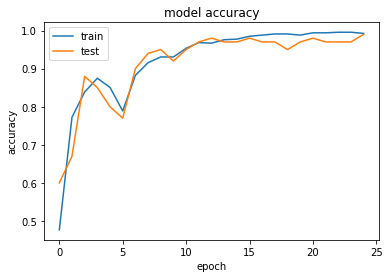

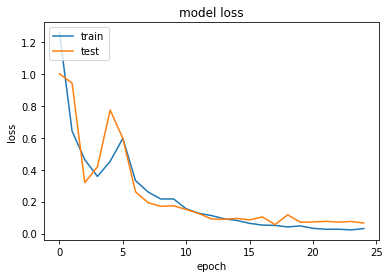

In [68]:
plot_loss_accuracy(history)

**OBSERVATION**: This is the final model that is a pick out of all as it has high accuracy and lowest validation loss.